In [1]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
aggr='mean'
# dropout = varying this below

# Training
batch_size = 32
epochs = 30
lr = 1e-4
maxlr = 3e-4

# Preprocess

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Dropout 0.0 GraphConv

In [6]:
dropout = 0.0

In [7]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.0, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [8]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [9]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7933 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7931 | Validation Loss: 1.7930
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7931 | Validation Loss: 1.7929
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7931 | Validation Loss: 1.7928
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7925 | Validation Loss: 1.7924
Train Acc: 0.1690 | Validation Acc: 0.1889
Train F1: 0.0765 | Validation F1: 0.0891

Epoch 7/30
Train Loss: 1.7921 | Validation Loss: 1.7921
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0832 | Validation F1: 0.0476

Epoch 8/30
Tr

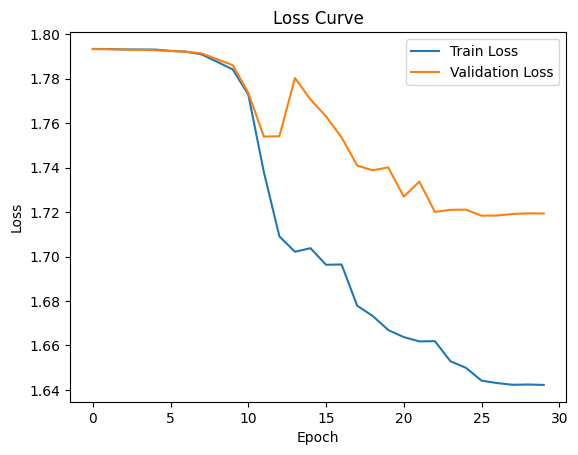

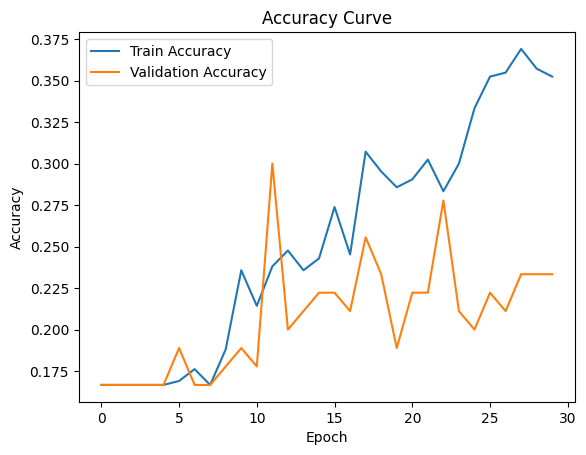

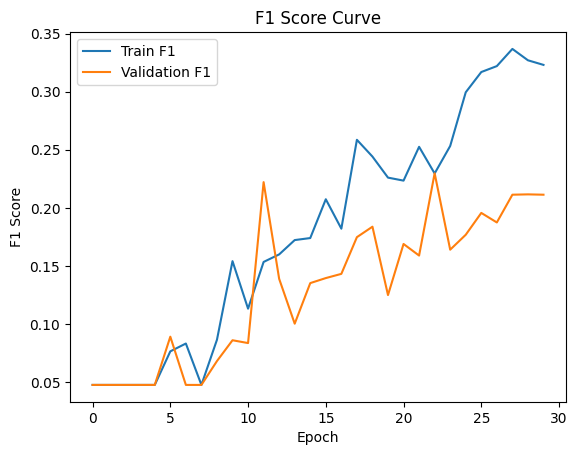

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7933,0.1667,0.1667,0.0476,0.0476
1,2,1.7933,1.7932,0.1667,0.1667,0.0476,0.0476
2,3,1.7931,1.7930,0.1667,0.1667,0.0476,0.0476
3,4,1.7931,1.7929,0.1667,0.1667,0.0476,0.0476
4,5,1.7931,1.7928,0.1667,0.1667,0.0476,0.0476
5,6,1.7925,1.7924,0.1690,0.1889,0.0765,0.0891
6,7,1.7921,1.7921,0.1762,0.1667,0.0832,0.0476
7,8,1.7909,1.7913,0.1667,0.1667,0.0476,0.0476
8,9,1.7876,1.7887,0.1881,0.1778,0.0865,0.0682
9,10,1.7841,1.7860,0.2357,0.1889,0.1541,0.0861


In [10]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.25 GraphConv

In [11]:
dropout = 0.25

In [12]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.25, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.25, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [13]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [14]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7935 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0525 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7933 | Validation Loss: 1.7933
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0607 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0636 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7930
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0473 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7931 | Validation Loss: 1.7929
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0477 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7928 | Validation Loss: 1.7926
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0676 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7927 | Validation Loss: 1.7925
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0869 | Validation F1: 0.0476

Epoch 8/30
Tr

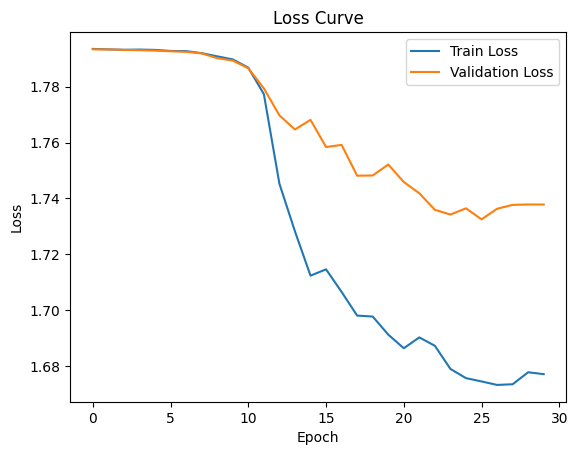

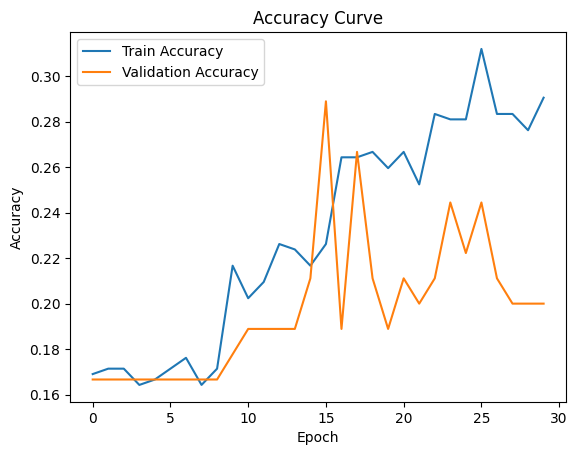

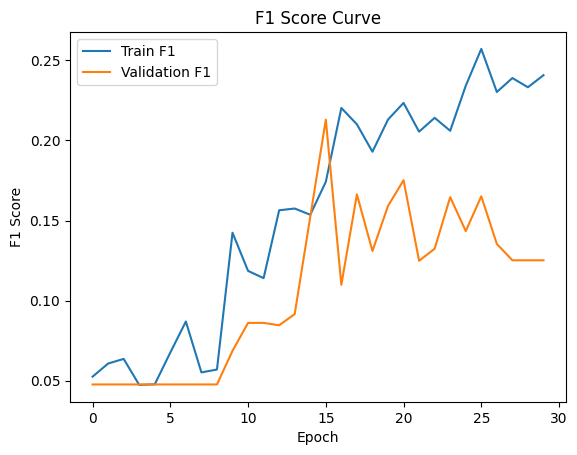

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7935,1.7934,0.1690,0.1667,0.0525,0.0476
1,2,1.7933,1.7933,0.1714,0.1667,0.0607,0.0476
2,3,1.7932,1.7932,0.1714,0.1667,0.0636,0.0476
3,4,1.7933,1.7930,0.1643,0.1667,0.0473,0.0476
4,5,1.7931,1.7929,0.1667,0.1667,0.0477,0.0476
5,6,1.7928,1.7926,0.1714,0.1667,0.0676,0.0476
6,7,1.7927,1.7925,0.1762,0.1667,0.0869,0.0476
7,8,1.7920,1.7919,0.1643,0.1667,0.0551,0.0476
8,9,1.7909,1.7902,0.1714,0.1667,0.0570,0.0476
9,10,1.7897,1.7893,0.2167,0.1778,0.1424,0.0686


In [15]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.5 GraphConv

In [16]:
dropout = 0.5 

In [17]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [19]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0800 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7935 | Validation Loss: 1.7933
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0754 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0774 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0679 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.0821 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7929 | Validation Loss: 1.7928
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0729 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7931 | Validation Loss: 1.7928
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0880 | Validation F1: 0.0476

Epoch 8/30
Tr

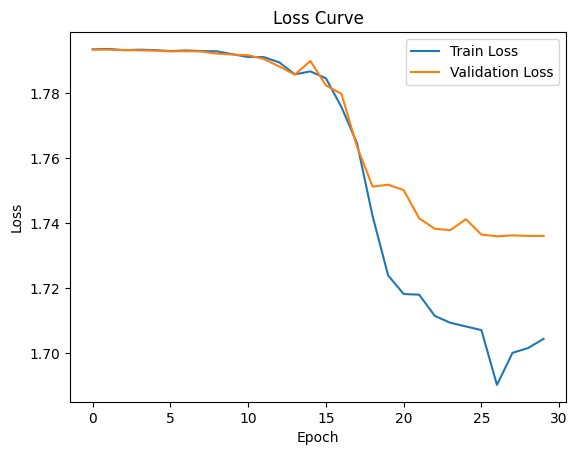

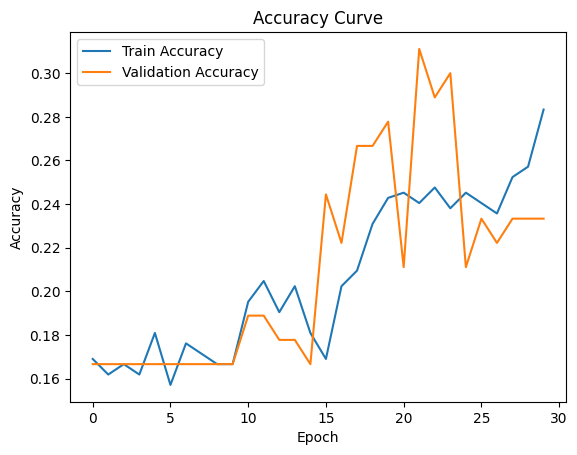

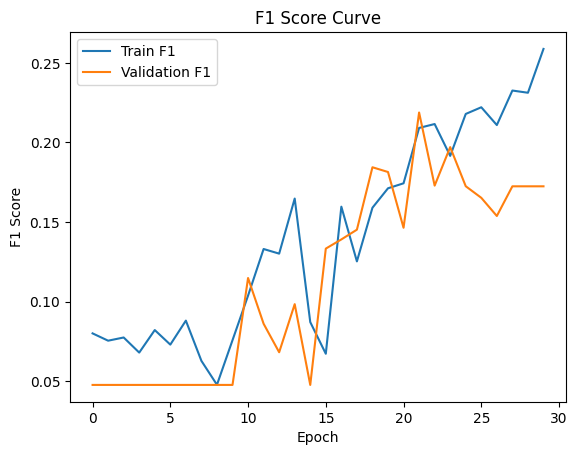

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7934,0.1690,0.1667,0.0800,0.0476
1,2,1.7935,1.7933,0.1619,0.1667,0.0754,0.0476
2,3,1.7932,1.7932,0.1667,0.1667,0.0774,0.0476
3,4,1.7933,1.7931,0.1619,0.1667,0.0679,0.0476
4,5,1.7932,1.7930,0.1810,0.1667,0.0821,0.0476
5,6,1.7929,1.7928,0.1571,0.1667,0.0729,0.0476
6,7,1.7931,1.7928,0.1762,0.1667,0.0880,0.0476
7,8,1.7929,1.7927,0.1714,0.1667,0.0627,0.0476
8,9,1.7928,1.7921,0.1667,0.1667,0.0477,0.0476
9,10,1.7919,1.7918,0.1667,0.1667,0.0757,0.0476


In [20]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.6 GraphConv

In [21]:
dropout = 0.6

In [22]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.6, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.6, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [23]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [24]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7933 | Validation Loss: 1.7934
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0774 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7936 | Validation Loss: 1.7933
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0899 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7933 | Validation Loss: 1.7932
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0789 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0706 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7931
Train Acc: 0.1595 | Validation Acc: 0.1667
Train F1: 0.0745 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7934 | Validation Loss: 1.7929
Train Acc: 0.1381 | Validation Acc: 0.1667
Train F1: 0.0654 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7931 | Validation Loss: 1.7930
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0861 | Validation F1: 0.0476

Epoch 8/30
Tr

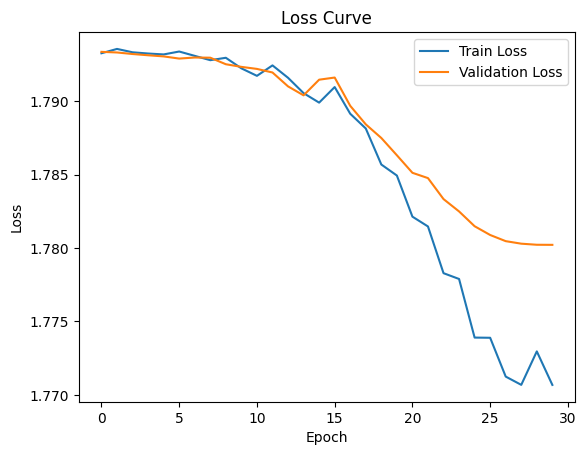

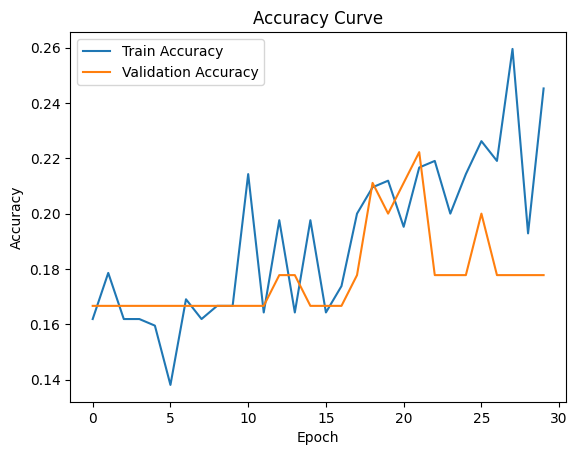

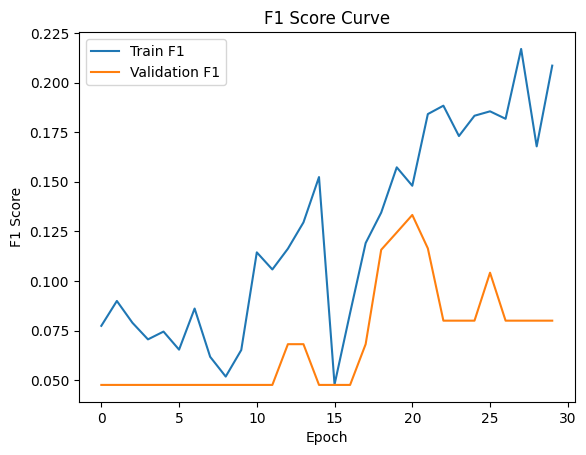

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7933,1.7934,0.1619,0.1667,0.0774,0.0476
1,2,1.7936,1.7933,0.1786,0.1667,0.0899,0.0476
2,3,1.7933,1.7932,0.1619,0.1667,0.0789,0.0476
3,4,1.7933,1.7931,0.1619,0.1667,0.0706,0.0476
4,5,1.7932,1.7931,0.1595,0.1667,0.0745,0.0476
5,6,1.7934,1.7929,0.1381,0.1667,0.0654,0.0476
6,7,1.7931,1.7930,0.1690,0.1667,0.0861,0.0476
7,8,1.7928,1.7930,0.1619,0.1667,0.0618,0.0476
8,9,1.7930,1.7925,0.1667,0.1667,0.0518,0.0476
9,10,1.7922,1.7923,0.1667,0.1667,0.0652,0.0476


In [25]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.7 GraphConv

In [26]:
dropout = 0.7

In [27]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.7, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.7, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [28]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [29]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7935 | Validation Loss: 1.7934
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0967 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0911 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7936 | Validation Loss: 1.7932
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.0884 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7938 | Validation Loss: 1.7932
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0775 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7936 | Validation Loss: 1.7931
Train Acc: 0.1595 | Validation Acc: 0.1667
Train F1: 0.0837 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7936 | Validation Loss: 1.7930
Train Acc: 0.1476 | Validation Acc: 0.1667
Train F1: 0.0762 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7930 | Validation Loss: 1.7930
Train Acc: 0.1881 | Validation Acc: 0.1667
Train F1: 0.0945 | Validation F1: 0.0476

Epoch 8/30
Tr

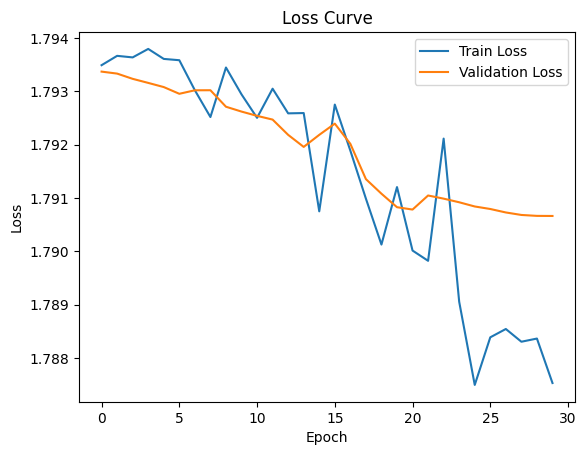

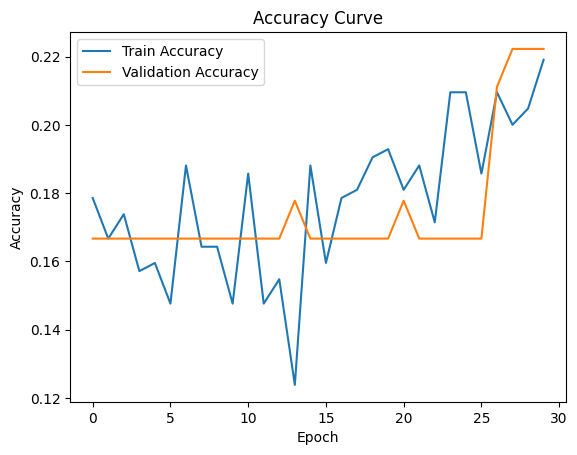

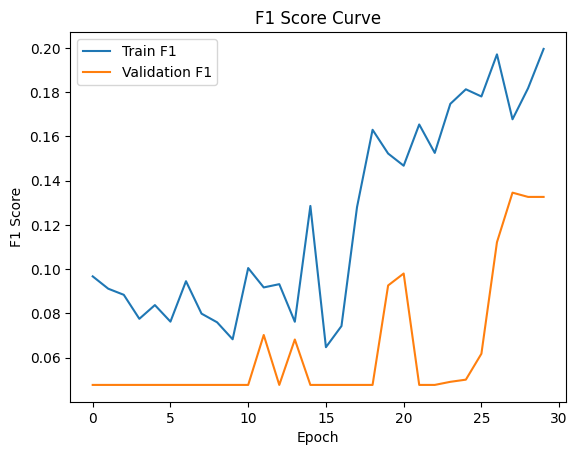

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7935,1.7934,0.1786,0.1667,0.0967,0.0476
1,2,1.7937,1.7933,0.1667,0.1667,0.0911,0.0476
2,3,1.7936,1.7932,0.1738,0.1667,0.0884,0.0476
3,4,1.7938,1.7932,0.1571,0.1667,0.0775,0.0476
4,5,1.7936,1.7931,0.1595,0.1667,0.0837,0.0476
5,6,1.7936,1.7930,0.1476,0.1667,0.0762,0.0476
6,7,1.7930,1.7930,0.1881,0.1667,0.0945,0.0476
7,8,1.7925,1.7930,0.1643,0.1667,0.0798,0.0476
8,9,1.7934,1.7927,0.1643,0.1667,0.0759,0.0476
9,10,1.7929,1.7926,0.1476,0.1667,0.0683,0.0476


In [30]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.8 GraphConv

In [31]:
dropout = 0.8

In [32]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.8, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.8, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [33]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [34]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7948 | Validation Loss: 1.7934
Train Acc: 0.1500 | Validation Acc: 0.1667
Train F1: 0.0844 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7952 | Validation Loss: 1.7933
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1117 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7940 | Validation Loss: 1.7933
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1025 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7939 | Validation Loss: 1.7932
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.1183 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7938 | Validation Loss: 1.7931
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0973 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7955 | Validation Loss: 1.7930
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1035 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7938 | Validation Loss: 1.7931
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0869 | Validation F1: 0.0476

Epoch 8/30
Tr

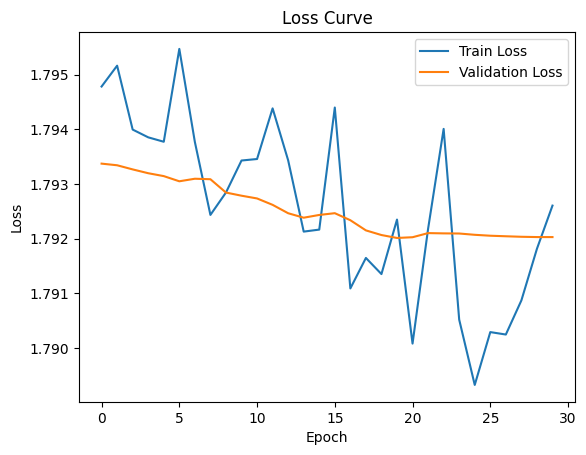

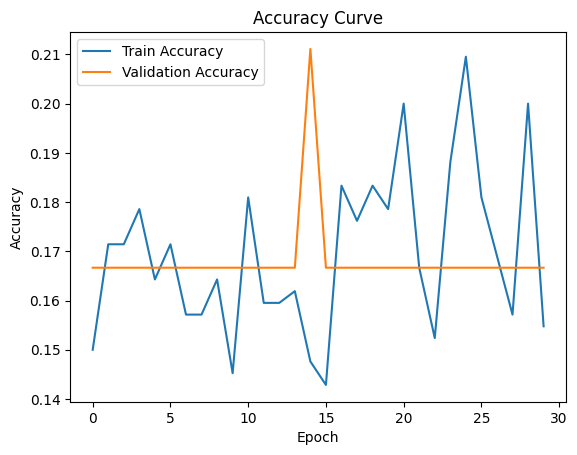

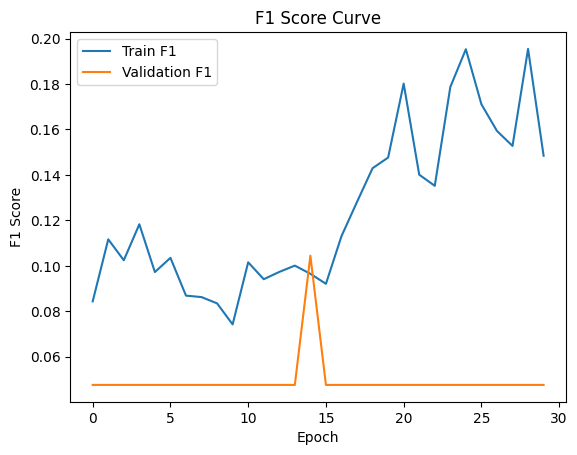

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7948,1.7934,0.1500,0.1667,0.0844,0.0476
1,2,1.7952,1.7933,0.1714,0.1667,0.1117,0.0476
2,3,1.7940,1.7933,0.1714,0.1667,0.1025,0.0476
3,4,1.7939,1.7932,0.1786,0.1667,0.1183,0.0476
4,5,1.7938,1.7931,0.1643,0.1667,0.0973,0.0476
5,6,1.7955,1.7930,0.1714,0.1667,0.1035,0.0476
6,7,1.7938,1.7931,0.1571,0.1667,0.0869,0.0476
7,8,1.7924,1.7931,0.1571,0.1667,0.0863,0.0476
8,9,1.7928,1.7928,0.1643,0.1667,0.0835,0.0476
9,10,1.7934,1.7928,0.1452,0.1667,0.0742,0.0476


In [35]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 0.9 GraphConv

In [36]:
dropout = 0.9

In [37]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.9, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.9, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)

In [38]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [39]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7961 | Validation Loss: 1.7934
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0921 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7957 | Validation Loss: 1.7934
Train Acc: 0.1548 | Validation Acc: 0.1667
Train F1: 0.1035 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.8022 | Validation Loss: 1.7933
Train Acc: 0.1452 | Validation Acc: 0.1667
Train F1: 0.0907 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7995 | Validation Loss: 1.7932
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.1106 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.8005 | Validation Loss: 1.7932
Train Acc: 0.1310 | Validation Acc: 0.1667
Train F1: 0.0866 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.8033 | Validation Loss: 1.7931
Train Acc: 0.1452 | Validation Acc: 0.1667
Train F1: 0.1081 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7950 | Validation Loss: 1.7931
Train Acc: 0.1548 | Validation Acc: 0.1667
Train F1: 0.1068 | Validation F1: 0.0476

Epoch 8/30
Tr

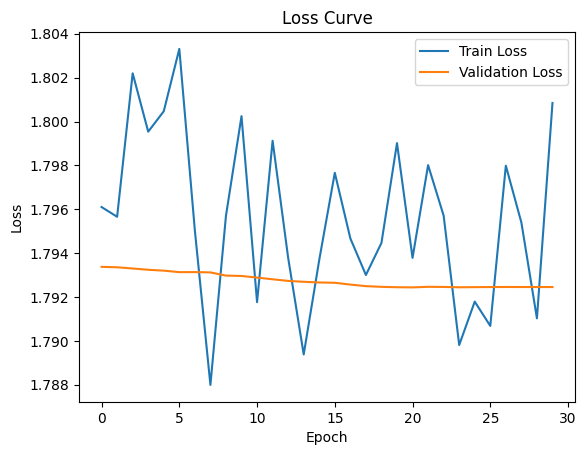

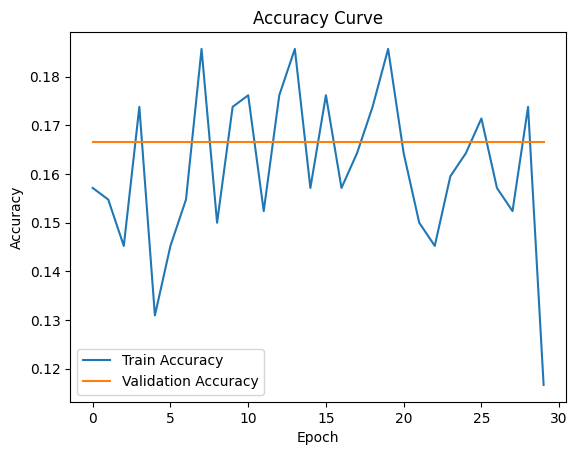

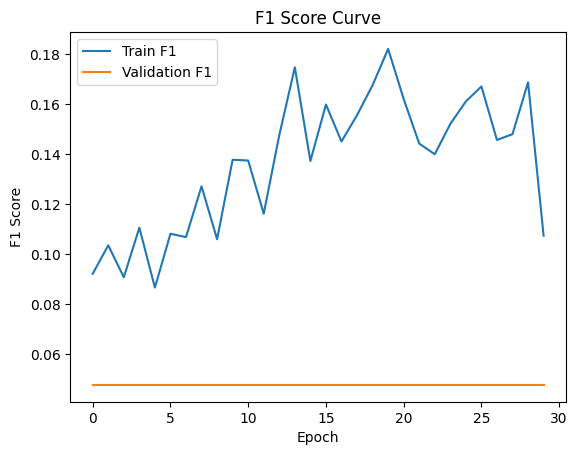

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7961,1.7934,0.1571,0.1667,0.0921,0.0476
1,2,1.7957,1.7934,0.1548,0.1667,0.1035,0.0476
2,3,1.8022,1.7933,0.1452,0.1667,0.0907,0.0476
3,4,1.7995,1.7932,0.1738,0.1667,0.1106,0.0476
4,5,1.8005,1.7932,0.1310,0.1667,0.0866,0.0476
5,6,1.8033,1.7931,0.1452,0.1667,0.1081,0.0476
6,7,1.7950,1.7931,0.1548,0.1667,0.1068,0.0476
7,8,1.7880,1.7931,0.1857,0.1667,0.1271,0.0476
8,9,1.7957,1.7930,0.1500,0.1667,0.1059,0.0476
9,10,1.8002,1.7930,0.1738,0.1667,0.1377,0.0476


In [40]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Dropout 1.0 GraphConv

In [41]:
dropout = 1.0

In [42]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=1.0, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=1.0, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=1.0, inplace=False)
)

In [43]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [44]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7937 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 8/30
Tr

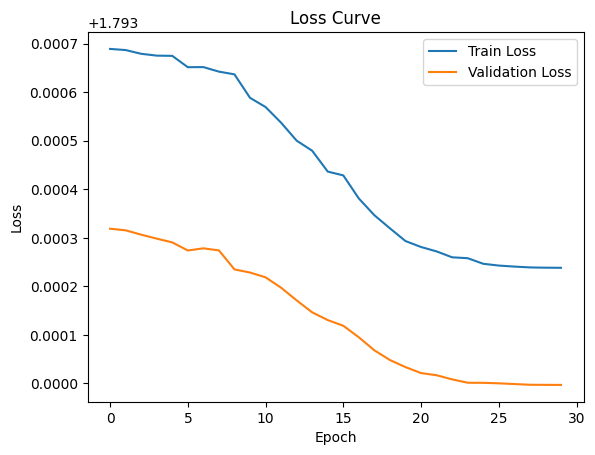

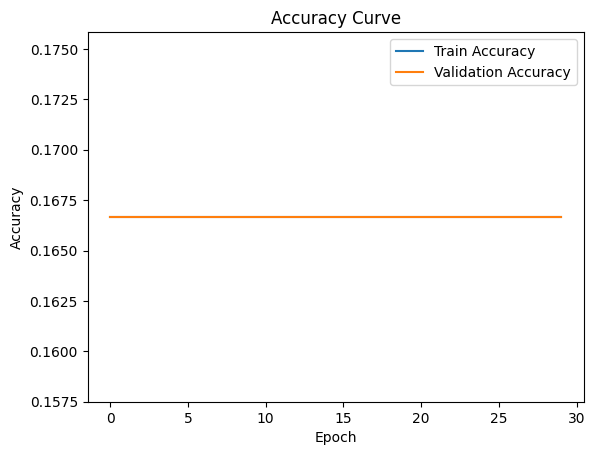

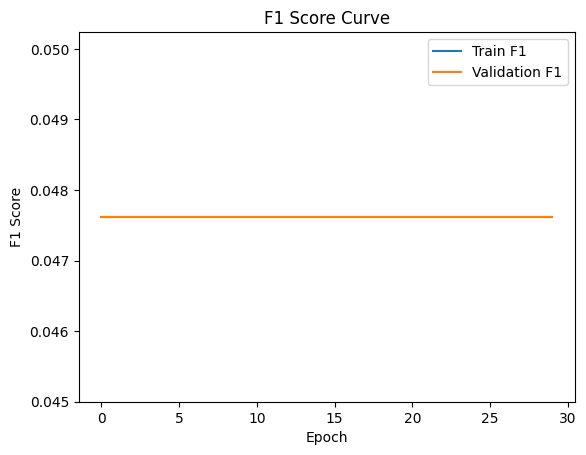

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
1,2,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
2,3,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
3,4,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
4,5,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
5,6,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
6,7,1.7937,1.7933,0.1667,0.1667,0.0476,0.0476
7,8,1.7936,1.7933,0.1667,0.1667,0.0476,0.0476
8,9,1.7936,1.7932,0.1667,0.1667,0.0476,0.0476
9,10,1.7936,1.7932,0.1667,0.1667,0.0476,0.0476


In [45]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)